In [221]:
import os

import glob
import fitsio

import itertools
import warnings

import numpy as np
import pylab as pl

import desisim.templates
import astropy.io.fits           as      fits

import desispec.io
import redrock.templates
import matplotlib.pyplot         as      plt

from   astropy.convolution       import  convolve, Box1DKernel
from   desispec.spectra          import  Spectra
from   desispec.frame            import  Frame
from   desispec.resolution       import  Resolution
from   desispec.io.meta          import  findfile
from   desispec.io               import  read_frame, read_fiberflat, read_flux_calibration, read_sky, read_fibermap 
from   desispec.interpolation    import  resample_flux
from   astropy.table             import  Table
from   desispec.io.image         import  read_image
from   specter.psf.gausshermite  import  GaussHermitePSF
from   scipy.signal              import  medfilt
from   desispec.calibfinder      import  CalibFinder
from   astropy.utils.exceptions  import  AstropyWarning
from   scipy                     import  stats
from   pathlib                   import  Path

In [20]:
warnings.simplefilter('ignore', category=AstropyWarning)

# Foundations to desispec ticket 1004:  Template SNR and LSS rad. weights.

Template SNR:

https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=4723;filename=sky-monitor-mc-study-v1.pdf;version=2

applied to SV0 dataset:

https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV0

# Template SNR

$\Huge \langle tSNR^2 \rangle = \sum_{grz} \sum_{\lambda \in grz} \left ( \frac{\tau^2 T^2 \langle \Delta F^2 \rangle}{\sigma_e^2 \cdot {\rm NPIX/A} + \tau T_{\rm sky}  F_{\rm sky}} \right ) $

_"We choose to normalize it such that zSNR = 3 for a 1000 sec dark time exposure in
nominal conditions."_

Here:  
- $\sigma_e$ is the READNOISE in units of ELECTRONS / PIXEL. 
- NPIX/A is the projected fiber area in units of PIXELS for a width of **ONE ANGSTROM**.  
- $\Delta F$ is the residual (template) flux from a 100A filtered equivalent.
- $\tau$ is the exposure time, already included in the flux calib.
- $T_{\rm sky} F_{\rm sky}$ is the estimated fiber sky flux in units of ELECTRONS PER ANGSTROM.

In [3]:
def templateSNR(template_flux, sky_flux=None, flux_calib=None, fiberflat=None, readnoise=None, npix=None, angstroms_per_pixel=None, fiberloss=None, flux_ivar=None):
    """
    Calculate template SNR, given either a model IVAR or cframe ivar.
        
    Args:
        template_flux: ergs/s/cm2/A 
        sky_flux: electrons/A
        flux_calib: 
        readnoise:electrons/pixel
        npix:
        angstroms_per_pixel: in the wavelength direction.
        fiberloss:
        flux_ivar: Equivalent to calibrated flux [ergs/s/cm2/A]. 
            
    Optional inputs:
        ...

    Returns:
        template S/N per camera.
    """
    # dlambda per pixel = 0.8; 100A / dlambda per pixel = 125. 
    sflux = convolve(template_flux, Box1DKernel(125))  
    dflux = template_flux - sflux 
    
    if flux_ivar is not None:
        # Work in calibrated flux units.
        # Assumes Poisson Variance from source is negligible.
        return  np.sum(flux_ivar * dflux ** 2.)

    else: 
        # Work in uncalibrated flux units (electrons per angstrom); flux_calib includes exptime. tau.
        dflux  *= flux_calib    # [e/A]
 
        # Wavelength dependent fiber flat;  Multiply or divide - check with Julien. 
        result  = dflux * fiberflat
        result  = result **2.
    
        if fiberloss is not None:
          lossless_fluxcalib = flux_calib / fiberloss
    
        # RDNOISE & NPIX assumed wavelength independent.
        denom   = readnoise**2 * npix / angstroms_per_pixel + fiberflat * sky_flux
        
        result /= denom
        
        # Eqn. (1) of https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=4723;filename=sky-monitor-mc-study-v1.pdf;version=2
        return  np.sum(result)

# Rad. LSS Class Definition

In [375]:
class RadLSS(object):
    def __init__(self, night, expid, cameras=None, andes='/global/cfs/cdirs/desi/spectro/redux/andes/'):
        """
        Creates a spectroscopic rad(ial) weights instance.
        
        Args:
            night: 
            expid: 
            
        Optional inputs:
            andes: 
        """
        
        # /global/cfs/cdirs/desi/spectro/redux/andes/'
        # self.andes          = '/global/scratch/mjwilson/desi-data.dm.noao.edu/desi/spectro/redux/andes/'
        self.andes            = andes
            
        # os.environ['DESIMODEL']            = '/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.13.0' 
        # os.environ['DESIMODEL']            = '/global/scratch/mjwilson/miniconda3/envs/desi/code/desimodel/'
        # os.environ['DESI_BASIS_TEMPLATES'] = '/global/scratch/mjwilson/desi-data.dm.noao.edu/desi/spectro/templates/basis_templates/v3.1/'
        # os.environ['DESI_SPECTRO_CALIB']   = self.andes + '/calibnight/'
        
        self.night            = night
        self.expid            = expid
        
        if cameras is None:
            petals            = np.arange(10)
            self.cameras      = [x[0] + x[1] for x in itertools.product(['b', 'r', 'z'], petals.astype(np.str))]

        else:
            self.cameras      = cameras
        
        # All petals with an available camera.
        self.petals           = np.unique(np.array([x[1] for x in self.cameras]))
        
        self.fail             = False
        self.flavor           = None
        
        self.templates        = {}
   
        self.nmodel           =  0
        self.ensemble_tracers = []
        self.ensemble_flux    = {}
        self.ensemble_meta    = {}
        self.ensemble_objmeta = {}
        self.template_snrs    = {}

        self.get_data()
 
        if self.flavor == 'science':
          self.get_gfas()
  
        else:
          raise ValueError('Non-science exposure')  

        '''
        try:
            self.get_data()

        except:
            print('Failed to retrieve raw and reduced data for expid {} and cameras {}'.format(expid, self.cameras))
            self.fail         = True
        '''       
    
        #  Don't write to original andes.
        self.outdir           = '/global/homes/m/mjwilson/radlss/tiles/{}/{}/'.format(self.tileid, self.night)
        self.qadir            = self.outdir + '/QA/'
        
        Path(self.outdir).mkdir(parents=True, exist_ok=True)
        
    def get_gfas(self, printit=False, root='/global/scratch/mjwilson', survey='SV0'):
      '''
      Get A. Meisner's GFA exposures .fits file.
      Yields seeing FWHM, Transparency and fiberloss for a given spectroscopic expid.
      '''  
    
      gfa_path   = '/global/cfs/cdirs/desi/users/ameisner/GFA/conditions/offline_all_guide_ccds_{}.fits'.format(survey)    
      # gfa_path = root + '/offline_all_guide_ccds_{}.fits'.format(survey)
        
      gfa        = Table.read(gfa_path)
    
      # Quality cuts. 
      # gfa        = gfa[gfa['SPECTRO_EXPID'] > -1]
      # gfa        = gfa[gfa['N_SOURCES_FOR_PSF'] > 2]
      # gfa        = gfa[gfa['CONTRAST'] > 2]
      # gfa        = gfa[gfa['NPIX_BAD_TOTAL'] < 10]

      gfa.sort('SPECTRO_EXPID')

      by_spectro_expid         = gfa.group_by('SPECTRO_EXPID')

      # np.mean
      self.gfa_median          = by_spectro_expid.groups.aggregate(np.median) 
          
      self.gfa_median_exposure = self.gfa_median[self.gfa_median['SPECTRO_EXPID'] == expid]
      self.gfa_median_exposure = self.gfa_median_exposure['SPECTRO_EXPID', 'FWHM_ASEC', 'TRANSPARENCY', 'FIBER_FRACFLUX', 'SKY_MAG_AB', 'MJD', 'NIGHT']
 
      self.fiberloss           = self.gfa_median_exposure['FIBER_FRACFLUX'][0]
        
      if printit:
          print(self.gfa_median)
       
    def get_data(self):    
        '''
        Grab the raw and reduced data for a given (SV0) expid.
        Bundle by camera (band, petal) for each exposure instance.
        '''
        
        # For each camera.
        self.frames     = {}
        self.cframes    = {}

        self.psfs       = {}
        self.skies      = {} 

        self.fluxcalibs = {}

        self.fiberflats = {}  # NOT including in the flux calibration. 
    
        self.fibermaps  = {} 
        
        self.psf_nights = {}

        self.preprocs   = {}
                
        for cam in self.cameras:
            # E.g.  /global/cfs/cdirs/desi/spectro/redux/andes/tiles/67230/20200314/cframe-z9-00055382.fits                      
            self.cframes[cam]    = read_frame(findfile('cframe', night=self.night, expid=self.expid, camera=cam, specprod_dir=self.andes))
                     
            self.exptime         = self.cframes[cam].meta['EXPTIME']
        
            self.mjd             = self.cframes[cam].meta['MJD-OBS']
            
            self.tileid          = self.cframes[cam].meta['TILEID']
                        
            self.night           = self.cframes[cam].meta['NIGHT']
                
            self.flavor          = self.cframes[cam].meta['FLAVOR']
                
            self.fibermaps[cam]  = self.cframes[cam].fibermap
                
            self._ofibermapcols  = list(self.cframes[cam].fibermap.dtype.names)
                
            self.fibermaps[cam]['TILEFIBERID'] = 10000 * self.tileid + self.fibermaps[cam]['FIBER']
                
            self.psfs[cam]       = GaussHermitePSF(findfile('psf', night=self.night, expid=self.expid, camera=cam, specprod_dir=self.andes))

            self.psf_nights[cam] = GaussHermitePSF(findfile('psfnight', night=self.night, expid=self.expid, camera=cam, specprod_dir=self.andes))
                
            self.skies[cam]      = read_sky(findfile('sky', night=self.night, expid=self.expid, camera=cam, specprod_dir=self.andes))
        
            # https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_CALIB/fluxcalib-CAMERA.html
            self.fluxcalibs[cam] = read_flux_calibration(findfile('fluxcalib', night=self.night, expid=self.expid, camera=cam, specprod_dir=self.andes))
        
            fiberflat_path       = os.environ['DESI_SPECTRO_CALIB'] + '/' + CalibFinder([self.cframes[cam].meta]).data['FIBERFLAT']
            
            # findfile('fiberflat', night=self.night, expid=flatid, camera=cam, specprod_dir=self.andes)
            self.fiberflats[cam] = read_fiberflat(fiberflat_path)
            self.flat_expid      = self.fiberflats[cam].header['EXPID']
        
            # If fail:  CalibFinder([rads.cframes['b5'].meta, rads.cframes['b5'].meta])?
        
            self.frames[cam]     = read_frame(findfile('frame', night=self.night, expid=self.expid, camera=cam, specprod_dir=self.andes))
                
            self.preprocs[cam]   = read_image(findfile('preproc', night=self.night, expid=self.expid, camera=cam, specprod_dir=self.andes))
            
    def calc_nea(self, psf_wave=None, write=False):
        '''
        Calculate the noise equivalent area for each fiber of a given 
        camera from the local psf.  Added to fibermap.
        
        Input:
          psf_wave:  wavelength at which to evaluate the PSF, e.g. 3727. * (1. + 1.1) 
        '''
        
        for cam in self.cameras:
            psf = self.psf_nights[cam]
            
            # Note:  psf.nspec, psf.npix_x, psf.npix_y
            if psf_wave is None:
              # Representative wavelength. 
              psf_wave = 3727. * (1. + 1.1)    
            
            if (psf_wave < self.cframes[cam].wave.min()) | (psf_wave > self.cframes[cam].wave.max()):
                psf_wave = np.median(self.cframes[cam].wave)
               
            fiberids = self.fibermaps[cam]['FIBER']
                
            #  Fiber centroid position on CCD.
            #  https://github.com/desihub/specter/blob/f242a3d707c4cba549030af6df8cf5bb12e2b47c/py/specter/psf/psf.py#L467
            #  x,y = psf.xy(fiberids, self.psf_wave)
            
            #  https://github.com/desihub/specter/blob/f242a3d707c4cba549030af6df8cf5bb12e2b47c/py/specter/psf/psf.py#L300
            #  Range that boxes in fiber 'trace':  (xmin, xmax, ymin, ymax)
            #  ranges = psf.xyrange(fiberids, self.psf_wave)
            
            #  Note:  Expectation of 3.44 for PSF size in pixel units (spectro paper).
            #  Return Gaussian sigma of PSF spot in cross-dispersion direction in CCD pixel units.
            #  Gaussian PSF, radius R that maximizes S/N for a faint source in the sky-limited case is 1.7σ
            #  http://www.ucolick.org/~bolte/AY257/s_n.pdf
            #  2. * 1.7 * psf.xsigma(ispec=fiberid, wavelength=oii)
            
            #  Gaussian sigma of PSF spot in dispersion direction in CCD pixel units.
            #  Gaussian PSF, radius R that maximizes S/N for a faint source in the sky-limited case is 1.7σ
            #  http://www.ucolick.org/~bolte/AY257/s_n.pdf
            #  2. * 1.7 * psf.ysigma(ispec=fiberid, wavelength=oii)
           
            neas             = []
            angstrom_per_pix = []
    
            for ifiber, fiberid in enumerate(fiberids):
              psf_2d = psf.pix(ispec=ifiber, wavelength=psf_wave)
            
              # norm = np.sum(psf_2d)
             
              # http://articles.adsabs.harvard.edu/pdf/1983PASP...95..163K
              neas.append(1. / np.sum(psf_2d ** 2.)) # [pixel units].

              angstrom_per_pix.append(psf.angstroms_per_pixel(ifiber, psf_wave))

            self.fibermaps[cam]['NEA']              = np.array(neas)
            self.fibermaps[cam]['ANGSTROMPERPIXEL'] = np.array(angstrom_per_pix)
            
            if write:
                raise  NotImplementedError()
                
    def calc_readnoise(self, psf_wave=None):
        '''
        Calculate the readnoise for each fiber of a given 
        camera from the patch matched to the local psf.
        Added to fibermap.
        
        Input:
          psf_wave:  wavelength at which to evaluate the PSF, e.g. 3727. * (1. + 1.1) 
        '''
        
        self.ccdsizes          = {}   
            
        for cam in self.cameras:
                self.ccdsizes[cam] = np.array(self.cframes[cam].meta['CCDSIZE'].split(',')).astype(np.int)
                            
                psf                = self.psf_nights[cam]
                        
                if psf_wave is None:
                  #  Representative wavelength. 
                  psf_wave = 3727. * (1. + 1.1)    
            
                if (psf_wave < rads.cframes[cam].wave.min()) | (psf_wave > rads.cframes[cam].wave.max()):
                  psf_wave = np.median(rads.cframes[cam].wave)
               
                fiberids   = self.fibermaps[cam]['FIBER']
        
                rd_noises      = []
            
                ccd_x          = []
                ccd_y          = []

                quads          = [] 
                rd_quad_noises = []
        
                def quadrant(x, y):
                    if (x < (self.ccdsizes[cam][0] / 2)):
                        if (y < (self.ccdsizes[cam][1] / 2)):
                            return  'A'
                        else:
                            return  'C'
                        
                    else:
                        if (y < (self.ccdsizes[cam][1] / 2)):
                            return  'B'
                        else:
                            return  'D'
                        
                for ifiber, fiberid in enumerate(fiberids):                
                    x, y                     = psf.xy(ifiber, psf_wave)
        
                    ccd_quad                 = quadrant(x, y)
    
                    (xmin, xmax, ymin, ymax) = psf.xyrange(ifiber, psf_wave)

                    # electrons/pixel (float).
                    rd_cutout = self.preprocs[cam].readnoise[ymin:ymax, xmin:xmax]
                    
                    rd_noises.append(np.median(rd_cutout))
        
                    ccd_x.append(x)
                    ccd_y.append(y)
        
                    quads.append(ccd_quad)
                    rd_quad_noises.append(self.cframes[cam].meta['OBSRDN{}'.format(ccd_quad)])
                        
                self.fibermaps[cam]['CCDX']         = np.array(ccd_x)
                self.fibermaps[cam]['CCDY']         = np.array(ccd_y)
                    
                self.fibermaps[cam]['RDNOISE']      = np.array(rd_noises)

                # https://github.com/desihub/spectropaper/blob/master/figures/ccdlayout.png
                self.fibermaps[cam]['QUAD']         = np.array(quads)
                self.fibermaps[cam]['RDNOISE_QUAD'] = np.array(rd_quad_noises)
            
    def calc_skycontinuum(self):
        # kernel_N      = 145
        # sky_continuum = medfilt(skies['z'].flux[0, :], kernel_N)

        # pl.plot(skies['z'].wave, sky_continuum)

        # pl.xlabel('Wavelength [Angstroms]')
        # pl.ylabel('Electrons per Angstrom')

        # pl.title('Sky continuum ({}A median filter)'.format(kernel_N * 0.8))
        raise  NotImplementedError()

    def calc_fiberlosses(self):
        '''
        Calculate the fiberloss for each fiber of a given 
        camera from the local psf.  Added to fibermap.
        
        Input:
          psf_wave:  wavelength at which to evaluate the PSF, e.g. 3727. * (1. + 1.1) 
        '''
        
        from  specsim.fastfiberacceptance import FastFiberAcceptance
        from  desimodel.io                import load_desiparams, load_fiberpos, load_platescale, load_tiles, load_deviceloc
        
        
        self.ffa = FastFiberAcceptance(os.environ['DESIMODEL'] + '/data/throughput/galsim-fiber-acceptance.fits')
      
        #- Platescales in um/arcsec
        ps       = load_platescale()
    
        for cam in self.cameras:
          x      = self.cframes[cam].fibermap['FIBER_X']
          y      = self.cframes[cam].fibermap['FIBER_Y']
              
          r      = np.sqrt(x**2 + y**2)
    
          # ps['radius'] in mm.
          radial_scale = np.interp(r, ps['radius'], ps['radial_platescale'])
          az_scale     = np.interp(r, ps['radius'], ps['az_platescale'])
    
          plate_scale  = np.sqrt(radial_scale, az_scale)
   
          psf          = rads.gfa_median_exposure['FWHM_ASEC'] 
        
          if np.isnan(psf):
              psf      = 1.2
            
              print('Ill defined PSF set to {:.2f} arcsecond for {} of {}.'.format(psf, cam, self.expid)) 
        
          # Gaussian assumption: FWHM_ARCSECOND to STD. 
          psf         /= 2.355

          # um
          psf_um       = psf * plate_scale
               
          # POINT, DISK or BULGE for point source, exponential profile or De Vaucouleurs profile
          morph_type   = np.array(self.cframes[cam].fibermap['MORPHTYPE'], copy=True)
    
          self.cframes[cam].fibermap['FIBERLOSS'] = np.ones(len(self.cframes[cam].fibermap))

          psf_um       = np.ones(len(self.cframes[cam].fibermap))        
          fiber_offset = np.zeros_like(psf_um)

          for t, o in zip(['DEV', 'EXP', 'PSF', 'REX'], ['BULGE', 'DISK', 'POINT', 'DISK']):  
              is_type  = (morph_type == t)
                
              # Optional: half light radii.   
              self.cframes[cam].fibermap['FIBERLOSS'][is_type] = self.ffa.rms(o, psf_um[is_type], fiber_offset[is_type])
    
    def rec_redrock_cframes(self):
        '''
        Reconstruct best-fit redrock template from DATA ZBEST. 
        Use this to calculate sourceless IVAR & template SNR.
        '''
        
        if not bool(self.templates): 
          for filename in redrock.templates.find_templates():
            t             = redrock.templates.Template(filename)
            self.templates[(t.template_type, t.sub_type)] = t

          print('Updated rr templates.')  
        
        templates       = self.templates
    
        self.rr_cframes = {}
        self.zbests     = {}
            
        for cam in self.cameras:
          petal      = cam[1] 
            
          # E.g. /global/scratch/mjwilson/desi-data.dm.noao.edu/desi/spectro/redux/andes/tiles/67230/20200314
          data_zbest_file = os.path.join(self.andes, 'tiles', str(self.tileid), str(self.night), 'zbest-{}-{}-{}.fits'.format(petal, self.tileid, self.night))
             
          self.zbests[petal] = zbest = Table.read(data_zbest_file, 'ZBEST')
                          
          rr_z       = zbest['Z']

          spectype   = [x.strip() for x in zbest['SPECTYPE']]
          subtype    = [x.strip() for x in zbest['SUBTYPE']]

          fulltype   = list(zip(spectype, subtype))
          
          ncoeff     = [templates[ft].flux.shape[0] for ft in fulltype]
 
          coeff      = [x[0:y] for (x,y) in zip(zbest['COEFF'], ncoeff)]
          
          tfluxs     = [templates[ft].flux.T.dot(cf)   for (ft, cf) in zip(fulltype, coeff)]
          twaves     = [templates[ft].wave * (1. + rz) for (ft, rz) in zip(fulltype, rr_z)]  

          Rs         = [Resolution(x) for x in self.cframes[cam].resolution_data]
          txfluxs    = [R.dot(resample_flux(self.cframes[cam].wave, twave, tflux)).tolist() for (R, twave, tflux) in zip(Rs, twaves, tfluxs)]
          txfluxs    =  np.array(txfluxs)
            
          # txflux  *= self.fluxcalibs[cam].calib     # [e/A].
          # txflux  /= self.fiberflats[cam].fiberflat # [e/A] (Instrumental).   

          # Estimated sourceless IVAR [ergs/s/A] ...  
          # Note:  assumed Poisson in Flux.  

          sless_ivar    = np.zeros_like(self.cframes[cam].ivar)
          rrsless_ivar  = np.zeros_like(self.cframes[cam].ivar)  
            
          # **  Sky-subtracted ** realized flux. 
          sless_ivar[self.cframes[cam].mask == 0]   = 1. / ((1. / self.cframes[cam].ivar[self.cframes[cam].mask == 0]) - self.cframes[cam].flux[self.cframes[cam].mask == 0])
            
          # Best-fit redrock template to the flux.
          rrsless_ivar[self.cframes[cam].mask == 0] = 1. / ((1. / self.cframes[cam].ivar[self.cframes[cam].mask == 0]) - txfluxs[self.cframes[cam].mask == 0])
                                    
          # print(self.cframes[cam].ivar.shape, sless_ivar.shape, rrsless_ivar.shape)
                
          # https://github.com/desihub/desispec/blob/6c9810df3929b8518d49bad14356d35137d25a89/py/desispec/frame.py#L41  
          self.rr_cframes[cam] = Frame(self.cframes[cam].wave, txfluxs, rrsless_ivar, mask=self.cframes[cam].mask, resolution_data=self.cframes[cam].resolution_data, fibermap=self.cframes[cam].fibermap, meta=self.cframes[cam].meta)

          rr_tsnrs             = []
          rr_tsnrs_sless       = []
          rr_tsnrs_rrsless     = []
          rr_tsnrs_modelivar   = []
            
          for j, template_flux in enumerate(self.rr_cframes[cam].flux):  
              # Best-fit redrock template & cframe ivar  [Calibrated flux].  
              rr_tsnrs.append(templateSNR(template_flux, flux_ivar=self.cframes[cam].ivar[j,:]))  

              # Best-fit redrock template & sourceless cframe ivar (cframe subtracted) [Calibrated flux].
              rr_tsnrs_sless.append(templateSNR(template_flux, flux_ivar=sless_ivar[j,:]))

              # Best-fit redrock template & sourceless cframe ivar (rr best-fit cframe subtracted) [Calibrated flux].
              rr_tsnrs_rrsless.append(templateSNR(template_flux, flux_ivar=rrsless_ivar[j,:]))
        
              # Model IVAR:
              sky_flux            = self.skies[cam].flux[j,:]  
              flux_calib          = self.fluxcalibs[cam].calib[j,:]   
              fiberflat           = self.fiberflats[cam].fiberflat[j,:] 
              readnoise           = self.cframes[cam].fibermap['RDNOISE'][j]  
              npix                = self.cframes[cam].fibermap['NEA'][j]  
              angstroms_per_pixel = self.cframes[cam].fibermap['ANGSTROMPERPIXEL'][j]  
                
              rr_tsnrs_modelivar.append(templateSNR(template_flux, sky_flux=sky_flux, flux_calib=flux_calib, fiberflat=fiberflat, readnoise=readnoise, npix=npix, angstroms_per_pixel=angstroms_per_pixel, fiberloss=None, flux_ivar=None))
        
          self.cframes[cam].fibermap['TSNR']           = np.array(rr_tsnrs)
          self.cframes[cam].fibermap['TSNR_SLESS']     = np.array(rr_tsnrs_sless)
          self.cframes[cam].fibermap['TSNR_RRSLESS']   = np.array(rr_tsnrs_rrsless)
          self.cframes[cam].fibermap['TSNR_MODELIVAR'] = np.array(rr_tsnrs_modelivar)
  
        # Reduce over cameras, for each petal.
        self.tsnrs                  = {}
        self.tsnr_types             = ['TSNR', 'TSNR_SLESS', 'TSNR_RRSLESS', 'TSNR_MODELIVAR']

        for tsnr_type in self.tsnr_types:
            self.tsnrs[tsnr_type]   = {}

        for tsnr_type in self.tsnr_types:
          for cam in self.cameras:
            petal  = cam[1]
            
            if petal not in self.tsnrs[tsnr_type].keys():
                self.tsnrs[tsnr_type][petal] = np.zeros(len(self.cframes[cam].fibermap))
            
            self.tsnrs[tsnr_type][petal] += self.cframes[cam].fibermap[tsnr_type]
    
    def ext_redrock_2Dframes(self, extract=False):
        from specter.extract.ex2d import ex2d
        
        
        self.rr_2Dframes                      = {}
        self.self.rr_2Dframe_spectroperf_ivar = {}
            
        for cam in self.cameras:
          psf        = self.psf_nights[cam]

          wave       = self.cframes[cam].wave
          nwave      = len(wave)
        
          nspec      = len(self.rr_cframes[cam].flux)
        
          xyrange    = (xmin, xmax, ymin, ymax) = psf.xyrange((0, nspec), wave)
          nx         = xmax - xmin
          ny         = ymax - ymin
        
          influx     = self.rr_cframes[cam].flux
        
          #- Generate a noiseless truth image and a noisy image (Poisson + read noise)
          # true_img   = psf.project(wave, influx*np.gradient(wave), xyrange=xyrange)

          # read_noise = np.median(self.fibermaps[cam]['RDNOISE'])
          # noisy_img  = np.random.poisson(true_img) + np.random.normal(scale=read_noise, size=true_img.shape)

          # self.rr_2Dframes[cam] = noisy_img  
        
          #- Run extractions with true ivar and estimated ivar
          # true_ivar     = 1.0 / (true_img + read_noise * read_noise)

          if extract:
            # IVAR by 'Spectro-Perfectionism'.
            flux, ivar, R1 = ex2d(noisy_img, true_ivar, psf, 0, nspec, wave, xyrange=xyrange)

            self.rr_2Dframe_spectroperf_ivar[cam] = ivar
    
            #- Resolution convolved influx -> model
            # model       = np.zeros((nspec, nwave))

            #  for i in range(nspec):
            #    model[i] = Resolution(R1[i]).dot(influx[i])
    
    def gen_template_ensemble(self, tracer='ELG', nmodel=50):  
        '''
        Generate an ensemble of templates to sample tSNR for a range of points in
        (z, m, OII, etc.) space.
        '''
        def tracer_maker(wave, tracer='ELG', nmodel=10):
            if tracer == 'ELG':
                maker = desisim.templates.ELG(wave=wave)
                
            elif tracer == 'QSO':
                maker = desisim.templates.QSO(wave=wave)

            elif tracer == 'LRG':
                 maker = desisim.templates.LRG(wave=wave)
                
            else:
                raise  ValueError('{} is not an available tracer.'.format(tracer))

            flux, wave, meta, objmeta = maker.make_templates(nmodel=nmodel)
        
            return  wave, flux, meta, objmeta

        for cam in self.cameras:
            band                               = cam[0]

            if (not band in self.ensemble_flux.keys()) | (self.nmodel != nmodel):            
                keys                           = set([key for key in self.cframes.keys() if key[0] in ['b','r','z']])
                keys                           = np.array(list(keys))
                                                        
                wave                           = self.cframes[keys[0]].wave
                                
                if len(keys) > 1:
                    for key in keys[1:]:
                        wave                   = np.concatenate((wave, self.cframes[key].wave))
                
                wave                           = np.unique(wave) # sorted.
                wave, flux, meta, objmeta      = tracer_maker(wave=wave, tracer=tracer, nmodel=nmodel)

                meta['MAG_G']                  = 22.5 - 2.5 * np.log10(meta['FLUX_G'])
                meta['MAG_R']                  = 22.5 - 2.5 * np.log10(meta['FLUX_R'])
                meta['MAG_Z']                  = 22.5 - 2.5 * np.log10(meta['FLUX_Z'])

                if tracer == 'ELG':
                    meta['OIIFLUX']            = objmeta['OIIFLUX']
                
                self.nmodel                    = nmodel
                
                # List of tracers computed.
                self.ensemble_tracers.append(tracer)

                self.ensemble_flux[tracer]     = {}
                self.ensemble_meta[tracer]     = meta
                self.ensemble_objmeta[tracer]  = objmeta
                         
                for band in ['b', 'r', 'z']:
                    band_key                         = [x[0] == band for x in keys]
                    band_key                         = keys[band_key][0]
                                            
                    band_wave                        = self.cframes[band_key].wave
                    
                    in_band                          = np.isin(wave, band_wave)
                    
                    self.ensemble_flux[tracer][band] = flux[:, in_band] 
                        
                if tracer == 'ELG':
                    indx   = np.argsort(self.ensemble_meta[tracer], order=['REDSHIFT', 'OIIFLUX', 'MAG'])

                    self.ensemble_meta[tracer]           = self.ensemble_meta[tracer][indx]
                    self.ensemble_objmeta[tracer]        = self.ensemble_objmeta[tracer][indx]        
                 
                    for band in ['b', 'r', 'z']:
                        self.ensemble_flux[tracer][band] = self.ensemble_flux[tracer][band][indx]
                
    def calc_templatesnrs(self, tracer='ELG'):
        '''
        Calculate template SNRs for the ensemble. 
        
        Result:
            [nfiber x ntemplate] array of tSNR values
            for each camera. 
        '''        
        if  len(self.ensemble_flux.keys()) == 0:
            self.gen_template_ensemble(tracer=tracer)
        
        self.template_snrs[tracer]  = {}
        
        for cam in self.cameras:  
            band                    = cam[0]
            
            nfiber                  = len(self.fibermaps[cam]['FIBER'])
            nmodel                  = len(self.ensemble_meta[tracer])
                
            self.template_snrs[tracer][cam]                   = {} 
             
            self.template_snrs[tracer][cam]['TSNR']           = np.zeros((nfiber, nmodel)) 
            self.template_snrs[tracer][cam]['TSNR_MODELIVAR'] = np.zeros((nfiber, nmodel)) 
            
            for ifiber, fiberid in enumerate(self.fibermaps[cam]['FIBER']):
                for j, template_flux in enumerate(self.ensemble_flux[tracer][band]):
                    sky_flux            = self.skies[cam].flux[ifiber,:]
                    flux_calib          = self.fluxcalibs[cam].calib[ifiber,:]
                    flux_ivar           = self.cframes[cam].ivar[ifiber, :]    
                    fiberflat           = self.fiberflats[cam].fiberflat[j,:] 
                    readnoise           = self.cframes[cam].fibermap['RDNOISE'][j]  
                    npix                = self.cframes[cam].fibermap['NEA'][j]  
                    angstroms_per_pixel = self.cframes[cam].fibermap['ANGSTROMPERPIXEL'][j]  
                
                    self.template_snrs[tracer][cam]['TSNR'][ifiber, j]           = templateSNR(template_flux, flux_ivar=flux_ivar)
                    self.template_snrs[tracer][cam]['TSNR_MODELIVAR'][ifiber, j] = templateSNR(template_flux, sky_flux=sky_flux, flux_calib=flux_calib,
                                                                                               fiberflat=fiberflat, readnoise=readnoise, npix=npix,
                                                                                               angstroms_per_pixel=angstroms_per_pixel, fiberloss=None,
                                                                                               flux_ivar=None)

        self.template_snrs[tracer]['brz'] = {}
            
        for cam in self.cameras:
            petal = cam[1]
            
            coadd = 'brz{}'.format(petal) 
            
            if coadd not in self.template_snrs[tracer].keys():
              self.template_snrs[tracer][coadd] = {}
            
            for tsnr_type in ['TSNR', 'TSNR_MODELIVAR']:
                if tsnr_type not in self.template_snrs[tracer][coadd].keys():
                    self.template_snrs[tracer][coadd][tsnr_type] = np.zeros_like(self.template_snrs[tracer][self.cameras[0]][tsnr_type]) 
              
                self.template_snrs[tracer][coadd][tsnr_type]    += self.template_snrs[tracer][cam][tsnr_type]
                        
    def run_ensemble_redrock(self, output_dir='/global/scratch/mjwilson/', tracer='ELG'):
        '''
        Run redrock on the template ensemble to test tSNR vs rr dX2 dependence.
        '''
        for cam in self.cameras:        
          band = cam[0]
            
          # TODO:  Add resolution, mask and sky noise to template flux for camera.  
          spec = Spectra([cam], {cam: self.cframes[cam].wave}, {cam: self.ensemble_flux[tracer][band]}, {cam: self.cframes[cam].ivar[:self.nmodel]}, resolution_data={cam: self.cframes[cam].resolution_data[:self.nmodel,:,:]}, mask={cam: self.cframes[cam].mask[:self.nmodel]}, fibermap=self.cframes[cam].fibermap[:self.nmodel], meta=None, single=False)
        
        # Overwrites as default.
        desispec.io.write_spectra(self.outdir + '/template-{}-ensemble-spectra.fits'.format(tracer.lower()), spec)
        
        # https://github.com/desihub/tutorials/blob/master/simulating-desi-spectra.ipynb
        self.zbest_file = os.path.join(self.outdir, 'template-{}-ensemble-zbest.fits'.format(tracer.lower()))

        # os.system('rm {}'.format(self.zbest_file))
        
        cmd     = 'rrdesi {} --zbest {}'.format(self.outdir + '/template-{}-ensemble-spectra.fits'.format(tracer.lower()), self.zbest_file)
        # srun  = 'srun -A desi -N 1 -t 00:10:00 -C haswell --qos interactive'
        # cmd   = '{} {} --mp 32'.format(srun, cmd)

        print(cmd)
        
        os.system(cmd)

        self.template_zbests = {}
        
        self.template_zbests[tracer] = Table.read(self.zbest_file, 'ZBEST')
        
    def write_radweights(self, output_dir='/global/scratch/mjwilson/'):
        '''
        Each camera, each fiber, a template SNR (redshift efficiency) as a function of redshift &
        target magnitude, per target class.  This could be for instance in the form of fits images in 3D
        (fiber x redshift x magnitude), with one HDU per target class, and one fits file per tile.
        '''
        for cam in self.cameras:            
          hdr             = fits.open(findfile('cframe', night=self.night, expid=self.expid, camera=cam, specprod_dir=self.andes))[0].header

          hdr['EXTNAME']  = 'RADWEIGHT'

          primary         = fits.PrimaryHDU(header=hdr)
          
          hdu_list        = [primary] + [fits.ImageHDU(self.template_snrs[tracer][cam]['TSNR_MODELIVAR'], name=tracer) for tracer in self.ensemble_tracers]  
 
          all_hdus        = fits.HDUList(hdu_list)

          all_hdus.writeto(self.outdir + '/radweights-{}-{:08d}.fits'.format(cam, self.expid), overwrite=True)

          #  Derived fibermap info.
          derived_cols    = [x for x in list(self.cframes[cam].fibermap.dtype.names) if x not in self._ofibermapcols]
 
          self.cframes[cam].fibermap[derived_cols].write(self.outdir + '/vadd-fibermap-{}-{:08d}.fits'.format(cam, self.expid), overwrite=True)
    
    def qa_plots(self, plots_dir=None):
        '''
        Generate QA plots under self.outdir(/QA/*).
        '''        
        if plots_dir is None:
            plots_dir = self.qadir

        colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 
            
        for cam in self.cameras:
          # ---------------  Skies  ---------------  
          pl.clf()
          pl.plot(self.skies[cam].wave, self.skies[cam].flux[0, :].T)
          pl.xlabel('Wavelength [Angstroms]')
          pl.ylabel('Electrons per Angstrom')
        
          Path(plots_dir + '/skies/').mkdir(parents=True, exist_ok=True)
        
          pl.savefig(plots_dir + '/skies/sky-{}.pdf'.format(cam))
        
          # ---------------  Flux calibration  ---------------
          fluxcalib          = self.fluxcalibs[cam].calib[0,:].T
          lossless_fluxcalib = fluxcalib / self.fiberloss 

          wave               = self.cframes[cam].wave
  
          pl.clf()
          pl.plot(wave, fluxcalib,          label='Flux calib.')
          pl.plot(wave, lossless_fluxcalib, label='Lossless flux calib.')

          pl.title('FIBERLOSS of {:.2f}'.format(self.fiberloss))

          pl.legend(loc=0, frameon=False)
            
          Path(plots_dir + '/fluxcalib/').mkdir(parents=True, exist_ok=True)
            
          pl.savefig(plots_dir + '/fluxcalib/fluxcalib-{}.pdf'.format(cam))  
        
          # ---------------  Fiber flats  ---------------
          xs = self.fibermaps[cam]['FIBERASSIGN_X']
          ys = self.fibermaps[cam]['FIBERASSIGN_Y']

          # Center on zero.
          fs = self.fiberflats[cam].fiberflat[:,0]
        
          pl.clf()
          pl.scatter(xs, ys, c=fs, vmin=0.0, vmax=2.0, s=2)
        
          Path(plots_dir + '/fiberflats/').mkdir(parents=True, exist_ok=True)
        
          pl.savefig(plots_dir + '/fiberflats/fiberflat-{}.pdf'.format(cam))   
            
          # ---------------  Read noise ---------------
          # NOTE: PSF_WAVE == OII may only test, e.g. two quadrants.
          pl.clf()
            
          fig, ax = plt.subplots(1, 1, figsize=(5., 5.))  
            
          for shape, cam in zip(['s', 'o', '*'], rads.cameras):
              for color, quad in zip(['r', 'b', 'c', 'm'], ['A', 'B', 'C', 'D']):    
                  in_quad = rads.fibermaps[cam]['QUAD'] == quad    
                  ax.plot(rads.fibermaps[cam]['RDNOISE'][in_quad], rads.fibermaps[cam]['RDNOISE_QUAD'][in_quad], marker='.', lw=0.0, c=color, markersize=4)

          xs = np.arange(10)

          ax.plot(xs, xs, alpha=0.4, c='k')

          ax.set_title('{} EXPID: {:d}'.format(rads.flavor.upper(), rads.expid))

          ax.set_xlim(2.0, 5.0)
          ax.set_ylim(2.0, 5.0)

          ax.set_xlabel('PSF median readnoise')
          ax.set_ylabel('Quadrant readnoise')
          
          Path(plots_dir + '/readnoise/').mkdir(parents=True, exist_ok=True)
            
          pl.savefig(plots_dir + '/readnoise/readnoise.pdf'.format(cam))
            
          # --------------- Template meta  ---------------
          # fig, axes = plt.subplots(1, 3, figsize=(20, 5))
  
          # for i, (band, color) in enumerate(zip(['MAG_G', 'MAG_R', 'MAG_Z'], ['b', 'g', 'r'])):
          #    axes[i].plot(meta[band], meta['REDSHIFT'], marker='.', c=color, lw=0.0)

          #    axes[i].set_xlabel('$REDSHIFT$')
          #    axes[i].set_ylabel('$' + band + '$')  
           
          # --------------- Redrock:  Template Ensemble  ---------------  
          # pl.plot(self.ensemble_meta['REDSHIFT'], zbest['Z'], marker='.', lw=0.0)

          # pl.plot(np.arange(0.7, 1.6, 0.1), np.arange(0.7, 1.6, 0.1), c='k', alpha=0.4)

          # pl.xlabel('TRUE    REDSHIFT')
          # pl.ylabel('REDROCK REDSHIFT')  
              
          # --------------- Redrock:  Data  --------------- 
          pl.clf()
        
          fig, axes = plt.subplots(1, len(self.tsnr_types), figsize=(20, 7.5))  
          
          for i, (color, tsnr_type) in enumerate(zip(colors, self.tsnr_types)):
            xs      = []
            ys      = []
            
            for petal in self.petals:
              xs   += self.tsnrs[tsnr_type][petal].tolist()
              ys   += self.zbests[petal]['DELTACHI2'].tolist()
            
              axes[i].loglog(self.tsnrs[tsnr_type][petal], self.zbests[petal]['DELTACHI2'], marker='.', lw=0.0, c=color, alpha=0.4)
  
            xs      = np.array(xs)
            ys      = np.array(ys)

            slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(xs[xs > 0.0]), np.log10(ys[xs > 0.0]))
        
            xs      = np.logspace(0., 4., 50)

            axes[i].loglog(xs, 10. ** (slope * np.log10(xs) + intercept), label='${:.3f} \cdot$ {} + {:.3f}'.format(slope, tsnr_type.upper(), intercept), c='k')

          for ax in axes:  
            ax.set_xlim(1., 1.e4)
            ax.set_ylim(1., 1.e4)
            
            ax.set_xlabel('TEMPLATE SNR')
            
            ax.set_ylabel('$\Delta \chi^2$')
            
            ax.legend(loc=2, frameon=False)
        
            ax.set_title('EXPID: {:08d}'.format(self.expid))
        
          Path(plots_dir + '/redrock/').mkdir(parents=True, exist_ok=True)
  
          pl.savefig(plots_dir + '/redrock/redrock-data-tsnr-{}.pdf'.format(cam))            
            
          # --------------- Template meta  ---------------
          # fig, axes = plt.subplots(1, 3, figsize=(20, 5))
  
          # for i, (band, color) in enumerate(zip(['MAG_G', 'MAG_R', 'MAG_Z'], ['b', 'g', 'r'])):
          #    axes[i].plot(meta[band], meta['REDSHIFT'], marker='.', c=color, lw=0.0)

          #    axes[i].set_xlabel('$REDSHIFT$')
          #    axes[i].set_ylabel('$' + band + '$')  
           
          # --------------- Redrock:  Template Ensemble  ---------------  
          # pl.plot(self.ensemble_meta['REDSHIFT'], zbest['Z'], marker='.', lw=0.0)

          # pl.plot(np.arange(0.7, 1.6, 0.1), np.arange(0.7, 1.6, 0.1), c='k', alpha=0.4)

          # pl.xlabel('TRUE    REDSHIFT')
          # pl.ylabel('REDROCK REDSHIFT')  
        
        pl.clf()
          
        fig, axes = plt.subplots(1, 4, figsize=(25,5))

        axes[0].imshow(np.log10(self.template_snrs['ELG']['brz5']['TSNR']), aspect='auto')  
        
        axes[1].imshow(np.broadcast_to(self.ensemble_meta['ELG']['REDSHIFT'],   (500, self.nmodel)), aspect='auto')
        axes[2].imshow(np.broadcast_to(self.ensemble_meta['ELG']['MAG'],        (500, self.nmodel)), aspect='auto')    
        axes[3].imshow(np.broadcast_to(self.ensemble_objmeta['ELG']['OIIFLUX'], (500, self.nmodel)), aspect='auto')  

        axes[0].set_title('TSNR')
        axes[1].set_title('REDSHIFT')
        axes[2].set_title('MAG')
        axes[3].set_title('OIIFLUX')
        
        for ax in axes: 
            ax.set_xlabel('TEMPLATE #')        
            ax.set_ylabel('FIBER')

        fig.suptitle('Petal {} of EXPID: {:08d}'.format(5, rads.expid))
           
        Path(plots_dir + '/TSNRs/').mkdir(parents=True, exist_ok=True)  
        
        pl.savefig(plots_dir + '/TSNRs/tsnr-ensemble-meta-{}.pdf'.format(petal))        
        
    def compute(self, templates=True, tracers=['ELG']):
        #  Process only science exposures.
        if self.flavor == 'science':        
          if (not self.fail):
              # try:
              self.calc_nea()
             
              self.calc_readnoise()
            
              # self.calc_skycontinuum()

              self.calc_fiberlosses()
            
              self.rec_redrock_cframes()
            
              # self.ext_redrock_2Dframes()  

              # -------------  Templates  --------------- 
              if templates:  
                for tracer in tracers:  
                  self.gen_template_ensemble(tracer=tracer)
             
                  self.calc_templatesnrs(tracer=tracer)

                  # self.run_ensemble_redrock(tracer=tracer)
    
                # tSNRs & derived fibermap info., e.g. NEA, RDNOISE, etc ... 
                self.write_radweights()
                    
              # -------------  QA  -------------            
              self.qa_plots()
              
              # except:
              # print('Failed to compute for expid {} and cameras {}'.format(expid, self.cameras))
              # self.fail = True
            
        else:
            print('Skipping non-science exposure: {:08d}'.format(self.expid))

In [365]:
def get_expids(night, andes=andes):
    return  np.sort(np.array([x.split('/')[-1] for x in glob.glob(andes + '/exposures/{}/*'.format(night))]).astype(np.int))

In [366]:
nmax     = 1
night    = '20200315'
tracers  = ['ELG']

expids   = get_expids(night)

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits
Updated rr templates.


<ipython-input-364-73d41fe2b70e>:424: RuntimeWarning: divide by zero encountered in true_divide
  sless_ivar[self.cframes[cam].mask == 0]   = 1. / ((1. / self.cframes[cam].ivar[self.cframes[cam].mask == 0]) - self.cframes[cam].flux[self.cframes[cam].mask == 0])
<ipython-input-364-73d41fe2b70e>:427: RuntimeWarning: divide by zero encountered in true_divide
  rrsless_ivar[self.cframes[cam].mask == 0] = 1. / ((1. / self.cframes[cam].ivar[self.cframes[cam].mask == 0]) - txfluxs[self.cframes[cam].mask == 0])


INFO:io.py:971:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/elg_templates_v2.2.fits
INFO:io.py:971:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/elg_templates_v2.2.fits
INFO:io.py:971:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/elg_templates_v2.2.fits
Ill defined PSF set to 1.20 arcsecond for b5 of 55589.
Ill defined PSF set to 1.20 arcsecond for r5 of 55589.
Ill defined PSF set to 1.20 arcsecond for z5 of 55589.
DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using 

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 1440x540 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 1440x540 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 1440x540 with 0 Axes>

<Figure size 1800x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 1440x540 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 1440x540 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 1440x540 with 0 Axes>

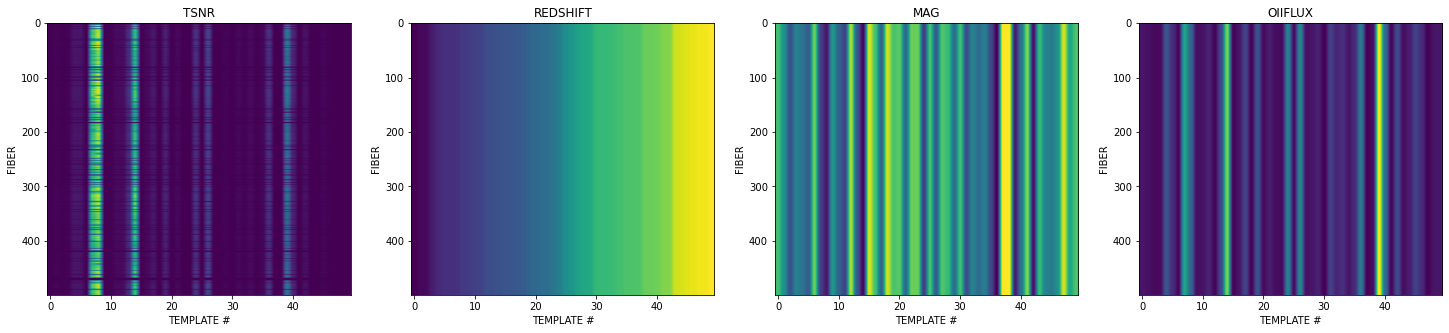

In [367]:
for nexp, expid in enumerate(expids[2:]):
    rads = RadLSS(night, expid, cameras=['b5', 'r5', 'z5'])
    
    rads.compute(tracers=tracers)
    
    if nexp == nmax:
      break

<ipython-input-374-95ec09f8326f>:5: RuntimeWarning: divide by zero encountered in log10
  axes[0].imshow(np.log10(rads.template_snrs['ELG']['brz5']['TSNR']), aspect='auto')


<Figure size 432x288 with 0 Axes>

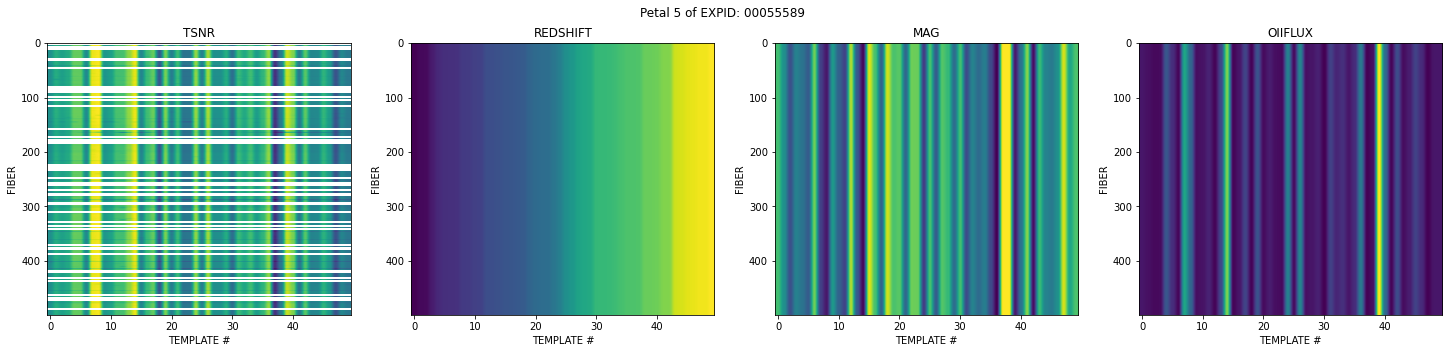

In [374]:
pl.clf()
          
fig, axes = plt.subplots(1, 4, figsize=(25,5))

axes[0].imshow(np.log10(rads.template_snrs['ELG']['brz5']['TSNR']), aspect='auto')  
        
axes[1].imshow(np.broadcast_to(rads.ensemble_meta['ELG']['REDSHIFT'],   (500, rads.nmodel)), aspect='auto')
axes[2].imshow(np.broadcast_to(rads.ensemble_meta['ELG']['MAG'],        (500, rads.nmodel)), aspect='auto')    
axes[3].imshow(np.broadcast_to(rads.ensemble_objmeta['ELG']['OIIFLUX'], (500, rads.nmodel)), aspect='auto')  

axes[0].set_title('TSNR')
axes[1].set_title('REDSHIFT')
axes[2].set_title('MAG')
axes[3].set_title('OIIFLUX')

fig.suptitle('Petal {} of EXPID: {:08d}'.format(5, rads.expid))

for ax in axes: 
    ax.set_xlabel('TEMPLATE #')        
    ax.set_ylabel('FIBER')

# Done.